<h1> Crawl links </h1>

In [1]:
import pandas as pd

from crawler import Crawler

In [2]:
crl = Crawler()

In [35]:
crl.home()

<selenium.webdriver.firefox.webdriver.WebDriver (session="ce82c57b-a942-4182-ac61-7dcec0362b20")>

In [41]:
for i in range(1,50):
    crl.load_more('fd-btn-more', 400)

In [43]:
soup = crl.get_soup()

In [44]:
content_item = soup.find_all("div", class_='content-item ng-scope')

In [45]:
link_items = []
for item in content_item:
    try:
        if int(item.find("div", class_='items-count').find_all('span')[0].text): # check if item have comment
            link_items.append(item.find('a')['href'])
    except: pass

In [46]:
len(link_items)

15

In [47]:
pd.DataFrame(link_items).to_csv('links_hn2.csv', index=False)

<h1> Fix broken link </h1>

In [3]:
import pandas as pd
import numpy as np

In [4]:
missing_path = 'https://www.foody.vn'

In [50]:
hn = pd.read_csv('links_hn.csv').to_numpy()
hcm = pd.read_csv('links_hn2.csv').to_numpy()

In [61]:
all_links = np.append(hn, hn)
all_links.shape[0]

2530

In [62]:
for i in range(all_links.shape[0]):
    if all_links[i][0] == '/':
        all_links[i] = missing_path + all_links[i]
    else:
        all_links[i] = all_links[i].replace('https://shopeefood.vn', missing_path)

In [63]:
df = pd.DataFrame(all_links)
df.head(10)

,0
0,https://www.foody.vn/ha-noi/com-suon-dao-duy-t...
1,https://www.foody.vn/ha-noi/sushi-garden
2,https://www.foody.vn/ha-noi/cuon-n-roll-restau...
3,https://www.foody.vn/ha-noi/mi-gia-tien-dat
4,https://www.foody.vn/ha-noi/pho-ga-95-doan-ke-...
5,https://www.foody.vn/ha-noi/banh-cuon-phu-ly-d...
6,https://www.foody.vn/ha-noi/com-nieu-singapore...
7,https://www.foody.vn/ha-noi/bun-rieu-cua-giang-vo
8,https://www.foody.vn/ha-noi/anh-hoa-french-bak...
9,https://www.foody.vn/ha-noi/vit-ham-hong-kong-...


In [71]:
df = df.drop_duplicates()

In [72]:
df.to_csv('links_all.csv', index=False)

<h1> Crawl restaurants </h1>

In [1]:
import csv
import time
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

from crawler import Crawler

In [2]:
links = pd.read_csv('links_all.csv').to_numpy().reshape(-1)
links.shape

(1265,)

In [3]:
crl = Crawler()
crl.home()

<selenium.webdriver.firefox.webdriver.WebDriver (session="4e0686c1-64e5-40fb-9221-2c9f86c1799d")>

In [4]:
# chuan hoa unicode utf8
import regex as re
 
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 
 
def loaddicchar():
    dic = {}
    
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [30]:
def crawl_comment(crl, link):
    crl.get(link)

    result = []

#     load whole page
#     while True:
#         crl.scroll_to_end()
#         try: crl.driver.find_element(By.XPATH, "//a[@ng-click='LoadMore()']").click()
#         except: break

    soup = crl.get_soup()

#     items = soup.find_all('li', class_='review-item')
    points = soup.find_all('div', class_='microsite-top-points')
#     address = soup.findall('div', class_='res-common-add')
    name = soup.find('h1', itemprop='name').text.replace('\n','')
    price = soup.find('span', itemprop='priceRange').text.replace('\n','')
    location_street = soup.find('span', itemprop='streetAddress').text.replace('\n','')
    location_district = soup.find('span', itemprop='addressLocality').text.replace('\n','')
    location_region = soup.find('span', itemprop='addressRegion').text.replace('\n','')
    location = location_street + ', ' + location_district + ', ' + location_region
    avgpoint = soup.find('div', class_='microsite-point-avg').text.replace('\n','')
    category = soup.find('div', class_='category')
    category = category.find('div').text.replace('\n','')
    num_reviews = soup.find('div', class_='microsite-review-count').text.replace('\n','')
    dishes = soup.find_all('div', class_='new-detail-info-area')
    service = soup.find('ul', class_='micro-property')
    properties = service.find_all('li')
    cuisines = soup.find_all('div', class_='delivery-dishes-item-right')
    # cuisine_list = []
    # dishes1 = bool(dishes[9].find('div', class_='new-detail-info-label').get_text(strip=True) == 'Phục vụ các món')
    for dish in dishes:
        if dish.find('div', class_='new-detail-info-label').get_text(strip=True) == 'Phục vụ các món':
#                 serve = 'ok'
            serve = dish.select_one("div div:nth-of-type(2)").text.replace('\n','')
#                 serve = dishes.select('div')[1].get_text(strip=True)
        if dish.find('div', class_='new-detail-info-label').get_text(strip=True) == 'Thời gian hoạt động':
            time = dish.select_one("div div:nth-of-type(2)").select_one("div span:nth-of-type(2)").text.replace('\n','')
    dieu_hoa = 0
    bong_da = 0
    wifi = 0
    # nation = soup.find('div', class_='microsite-cuisine').text.replace('\n','')
    for prop in properties:
        if prop.select_one("li a:nth-of-type(1)").get_text(strip=True) == 'Có máy lạnh & điều hòa':
            dieu_hoa += 1
        if prop.select_one("li a:nth-of-type(1)").get_text(strip=True) == 'Có chiếu bóng đá':
            bong_da += 1
        if prop.select_one("li a:nth-of-type(1)").get_text(strip=True) == 'Có wifi':
            wifi += 1
    # for i in cuisines:
    #     cuisine = i.find('div',class_='title-name ng-binding ng-isolate-scope').text.replace('\n','')
    #     price_cuisine = i.find('span', class_='price ng-binding').text.replace('\n','')
    #     cuisine_info = cuisine + ',' + price_cuisine
    #     cuisine_list.append([cuisine_info])
    cuisine_list = []       
    for i in cuisines:
        cuisine = i.find('div',class_='title-name ng-binding ng-isolate-scope').text.replace('\n','')
        price_cuisine = i.find('span', class_='price ng-binding').text.replace('\n','').replace('đ','')
        cuisine_info = cuisine + '-' + price_cuisine
        cuisine_info = str(cuisine_info)
        cuisine_list += [cuisine_info]
    cuisine_list = '|'.join(cuisine_list)
    result.append([name,price,avgpoint,category,location,num_reviews,serve,time,dieu_hoa,bong_da,wifi,cuisine_list])
    # result.append([name,price,location])

    # for point in points:
    #     try:
    #         category = point.find('div', class_='label').text.replace('\n',' ')
    #         category = covert_unicode(category)
    #         review = point.find('span').text.replace('\n','')
    #     except: continue

    #     result.append([category, review])
        
    return result



In [ ]:
data = []
for j in range(1,1000):
    try:
        data += crawl_comment(crl, links[j])
    except: print('j')
with open('dss_data_8_1.txt', mode='a', encoding="utf-8") as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerows(data)

In [37]:
with open('dss_data_8_1.txt', 'r', encoding="utf8") as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(";", 11) for line in stripped if line)
    with open('foodytest_8_1.csv', 'w', encoding="utf8") as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('name', 'price','avgpoint','category','location','num_reviews','dish_categories','time_open','dieu_hoa','bong_da','wifi','cuisines'))
        writer.writerows(lines)

In [38]:
import pandas as pd
data = pd.read_csv('foodytest_8_1.csv')

In [39]:
data = data.drop_duplicates()

In [278]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [40]:
data

,name,price,avgpoint,category,location,num_reviews,dish_categories,time_open,dieu_hoa,bong_da,wifi,cuisines
0,Sushi Garden,50.000đ - 150.000đ,7.2,Quán ăn,"310 Nguyễn Trãi, P. Thanh Xuân Trung, Quận Tha...",67,"Lẩu, Sushi & Sashimi, Salad, Ăn vặt - Ăn nhẹ, ...",10:00 - 22:00,1,0,1,"Set Cá Hồi, Lươn-159,000|Set Nigiri Tổng Hợp-1..."
1,Cuốn N Roll Restaurant - Giảng Võ,40.000đ - 468.000đ,7.1,Nhà hàng,"Tầng 3 Tòa Nhà D2, Giảng Võ, P. Giảng Võ, Quận...",64,"Heo quay, Bún, Lẩu, Món Huế, Ăn vặt - Ăn nhẹ",17:00 - 21:30 | 09:00 - 13:30,1,0,1,"Giỏ Quà Tết Yêu Thương-458,000|Cốt Lẩu Chua Ca..."
2,Mì Gia Tiến Đạt,35.000đ - 40.000đ,7.6,Quán ăn,"1 Lê Duẩn, Quận Ba Đình, Hà Nội",18,"Bún, Hủ tiếu, Mì, Món nước, Sủi cảo, Dimsum",14:00 - 00:00,0,0,0,"Mì Vằn Thắn Nước-55,000|Mì Vằn Thắn Trộn-55,00..."
3,Phở Gà 95 - Doãn Kế Thiện,25.000đ - 50.000đ,7.0,Quán ăn,"95 Doãn Kế Thiện, P. Mai Dịch, Quận Cầu Giấy, ...",1,"Thịt Gà, Phở, Món nước, Cháo, Miến",06:00 - 22:00,0,0,0,"Quẩy-6,000|Phở Gà-40,000|Phở Bò-40,000|Phở Gà ..."
4,Bánh Cuốn Phủ Lý - Đào Duy Từ,30.000đ - 55.000đ,7.0,Quán ăn,"39 Đào Duy Từ, Quận Hoàn Kiếm, Hà Nội",9,"Bánh ướt, Bún, Bánh - Kẹo, Bánh cuốn, Ăn vặt -...",07:00 - 14:30,0,0,0,"Bánh Cuốn Hành Phi Thịt Nướng-35,000|Bánh Cuốn..."
...,...,...,...,...,...,...,...,...,...,...,...,...
906,Cộng Cà Phê - Hàng Điếu,20.000đ - 50.000đ,7.1,Café/Dessert,"54 Hàng Điếu, Quận Hoàn Kiếm, Hà Nội",21,"Café - Kem, Sinh tố - Nước ép, Thức uống",07:30 - 23:30,1,0,1,"Trà Phê Sữa Mật (nóng)-49,000|Trà Quế Cốm Sữa ..."
907,Hạnh - Hải Sản Tươi Sống,50.000đ - 100.000đ,3.7,Ăn vặt/vỉa hè,"45 Cầu Gỗ, P. Hàng Bạc, Quận Hoàn Kiếm, Hà Nội",10,"Bún, Hải sản, Miến, Nghêu - Sò - Ốc",08:00 - 22:30,0,0,0,"Miến Xào Cua-100,000|Sò Dương-120,000|Sò Huyết..."
908,Phở Cường - Hàng Muối,25.000đ - 33.000đ,6.6,Quán ăn,"23 Hàng Muối, Quận Hoàn Kiếm, Hà Nội",33,"Phở, Thịt Bò, Món nước",06:30 - 22:00,0,0,0,"Phở Bò Tái-50,000|Phở Bò Chín-85,000"
909,Thọ Lòng - Cháo Lòng & Tiết Canh,20.000đ - 50.000đ,7.4,Quán ăn,"246 Trân Cung, Quận Bắc Từ Liêm, Hà Nội",1,"Cháo, Ăn vặt - Ăn nhẹ",06:00 - 22:00,0,0,0,NaN


In [41]:
data['cuisines'].isna().sum()

220

In [42]:
data['price'] = data['price'].str.replace("đ","")

In [43]:
data['price'] = data['price'].str.replace(".","")

In [44]:
data[['min_price','max_price']] = data['price'].str.split('-',expand=True)

In [45]:
data['max_price'] = data['max_price'].astype(int)
data['min_price'] = data['min_price'].astype(int)

In [46]:
data['avg_price'] = data[['min_price', 'max_price']].mean(axis=1)

In [47]:
data.head()

,name,price,avgpoint,category,location,num_reviews,dish_categories,time_open,dieu_hoa,bong_da,wifi,cuisines,min_price,max_price,avg_price
0,Sushi Garden,50000 - 150000,7.2,Quán ăn,"310 Nguyễn Trãi, P. Thanh Xuân Trung, Quận Tha...",67,"Lẩu, Sushi & Sashimi, Salad, Ăn vặt - Ăn nhẹ, ...",10:00 - 22:00,1,0,1,"Set Cá Hồi, Lươn-159,000|Set Nigiri Tổng Hợp-1...",50000,150000,100000.0
1,Cuốn N Roll Restaurant - Giảng Võ,40000 - 468000,7.1,Nhà hàng,"Tầng 3 Tòa Nhà D2, Giảng Võ, P. Giảng Võ, Quận...",64,"Heo quay, Bún, Lẩu, Món Huế, Ăn vặt - Ăn nhẹ",17:00 - 21:30 | 09:00 - 13:30,1,0,1,"Giỏ Quà Tết Yêu Thương-458,000|Cốt Lẩu Chua Ca...",40000,468000,254000.0
2,Mì Gia Tiến Đạt,35000 - 40000,7.6,Quán ăn,"1 Lê Duẩn, Quận Ba Đình, Hà Nội",18,"Bún, Hủ tiếu, Mì, Món nước, Sủi cảo, Dimsum",14:00 - 00:00,0,0,0,"Mì Vằn Thắn Nước-55,000|Mì Vằn Thắn Trộn-55,00...",35000,40000,37500.0
3,Phở Gà 95 - Doãn Kế Thiện,25000 - 50000,7.0,Quán ăn,"95 Doãn Kế Thiện, P. Mai Dịch, Quận Cầu Giấy, ...",1,"Thịt Gà, Phở, Món nước, Cháo, Miến",06:00 - 22:00,0,0,0,"Quẩy-6,000|Phở Gà-40,000|Phở Bò-40,000|Phở Gà ...",25000,50000,37500.0
4,Bánh Cuốn Phủ Lý - Đào Duy Từ,30000 - 55000,7.0,Quán ăn,"39 Đào Duy Từ, Quận Hoàn Kiếm, Hà Nội",9,"Bánh ướt, Bún, Bánh - Kẹo, Bánh cuốn, Ăn vặt -...",07:00 - 14:30,0,0,0,"Bánh Cuốn Hành Phi Thịt Nướng-35,000|Bánh Cuốn...",30000,55000,42500.0


<h1>Visualization<h1\>

In [48]:
import matplotlib as plt

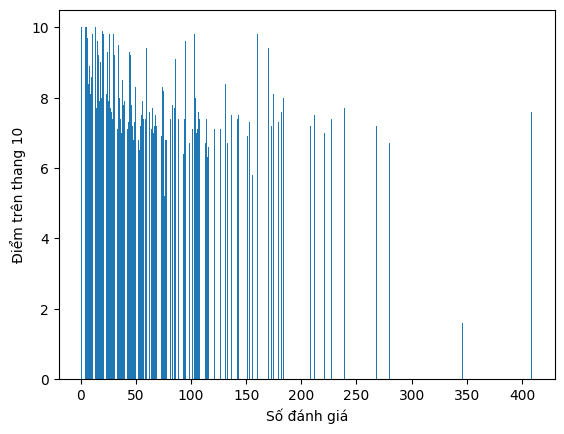

In [49]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

plt.bar(data['num_reviews'], data['avgpoint'])
plt.xlabel("Số đánh giá")
plt.ylabel("Điểm trên thang 10")
plt.show()

In [ ]:
fig,ax = plt.subplots()
data['category'].value_counts().plot(ax = ax, kind = 'pie', ylabel = '')
plt.show()

In [51]:
import seaborn as sns

<AxesSubplot:xlabel='avgpoint', ylabel='num_reviews'>

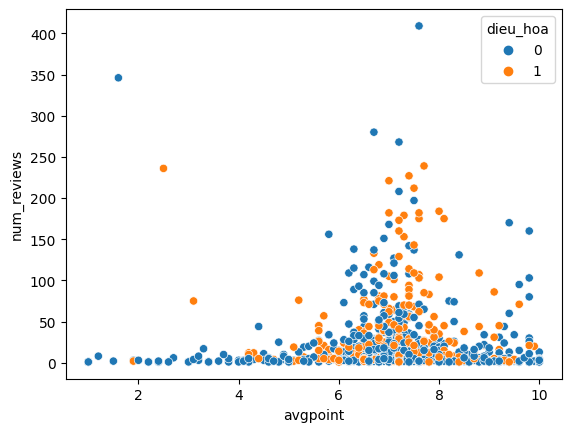

In [52]:
sns.scatterplot(data=data, x="avgpoint", y="num_reviews", hue="dieu_hoa")


<AxesSubplot:xlabel='avgpoint', ylabel='max_price'>

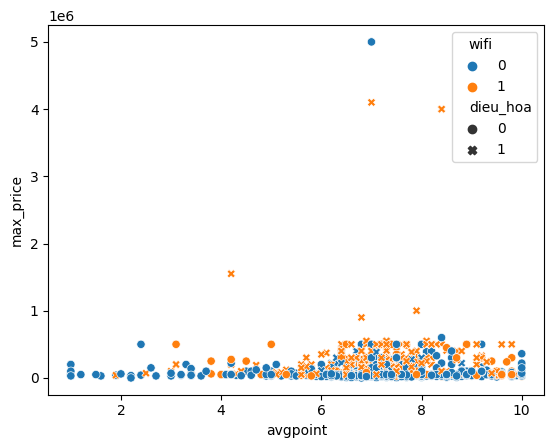

In [53]:
sns.scatterplot(data=data, x="avgpoint", y="max_price", hue="wifi", style ="dieu_hoa")

<AxesSubplot:xlabel='avgpoint', ylabel='avg_price'>

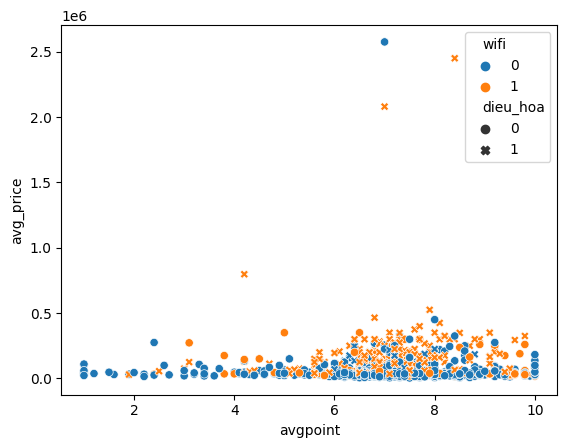

In [54]:
sns.scatterplot(data=data, x="avgpoint", y="avg_price", hue="wifi", style ="dieu_hoa")

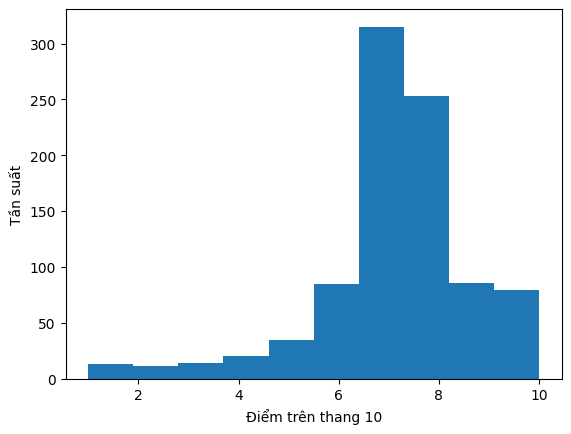

In [55]:
plt.hist(data['avgpoint'])
plt.xlabel("Điểm trên thang 10")
plt.ylabel("Tần suất")
plt.show()